In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linprog
from datetime import datetime
from datetime import timedelta as dt_timedelta

from renewableopt.data import load_by_day
from renewableopt.optimal_design import SinglePeriodModel, MultiPeriodModel, greedy_battery_control, visualize
from renewableopt.peak_id import gamma_matrix, timedelta, identify_worst_days, assert_int


In [2]:
time, load, solar_pu = load_by_day(0, 366)
time = time / 60
dt = timedelta(time)

In [3]:
worst_load, worst_solar_pu = identify_worst_days(time, load, solar_pu)

In [4]:
print(list(worst_load.keys()))

['low_load_low_solar', 'medium_load_low_solar', 'medium_load_medium_solar', 'high_load_cloudy', 'high_load_sunny']


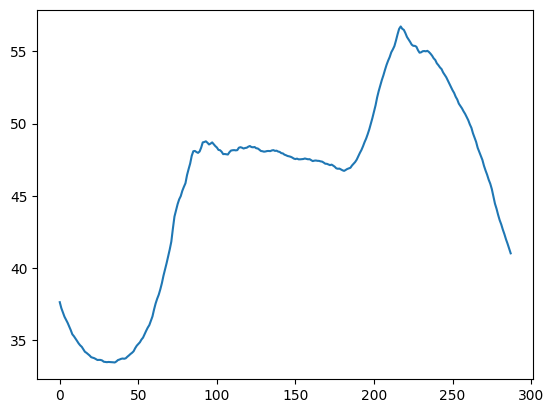

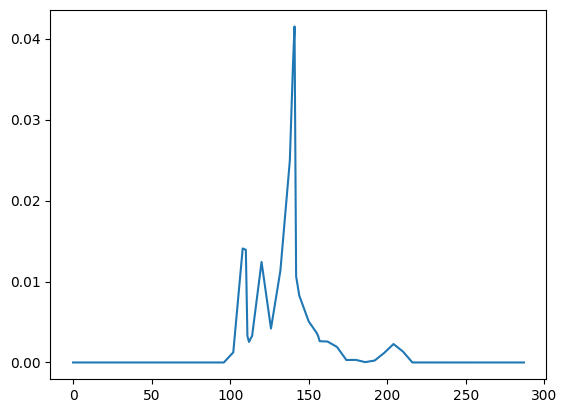

In [5]:
scenario = 'low_load_low_solar'
time_hr = time / 60
plt.plot(worst_load[scenario])
plt.figure()
plt.plot(worst_solar_pu[scenario])

In [8]:
time_one_day = time[:worst_load[scenario].shape[0]]
model = MultiPeriodModel(
    initial_battery_charge=0.5,
    depth_of_discharge=0.1,
    cost_battery_energy=100,
    cost_battery_power=10,
    cost_solar=10)
res = model.minimize_cost(time_one_day, worst_load, worst_solar_pu)

In [11]:
# Potentially interesting plots:
# Aggregated SoC at end of day (mean/std of each month) (of course, this depends on eta)
#     Include also minimum SoC
# SoC over day for the day in each month that reaches minimum battery capacity 
# Amount of renewable generation curtailment (to what degree is this a function of generation source?)

In [ ]:
# Is there a good way to store all this data in a single data structure, so that passing it
# to visualization function isn't so onerous?

In [13]:
dt = timedelta(time)
timesteps_per_day = assert_int(24 / dt)
u_batt_year, soc_year = greedy_battery_control(res, load, solar_pu * res.P_solar)
generation = solar_pu * res.P_solar
curtailment = generation - load - u_batt_year

In [14]:
# Reshape into "per-day" arrays. (Each row of array is it's own day.)
u_batt_per_day = u_batt_year.reshape(-1, timesteps_per_day)
soc_per_day = soc_year.reshape(-1, timesteps_per_day)
generation_per_day = generation.reshape(-1, timesteps_per_day)
load_per_day = load.reshape(-1, timesteps_per_day)
curtailment_by_day = curtailment.reshape(-1, timesteps_per_day)

In [19]:
res.P_solar / 1000

20.954493167705017

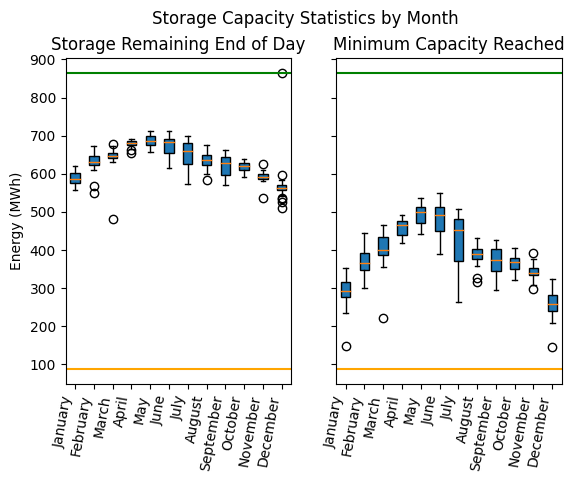

In [29]:
visualize.storage_capacity_statistics(res, soc_per_day)

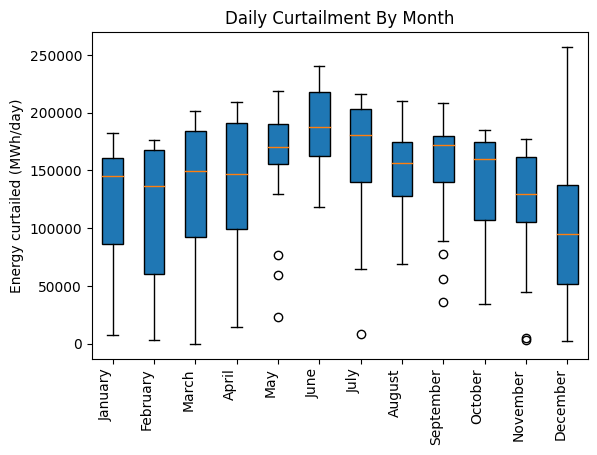

In [30]:
visualize.daily_curtailment(dt, curtailment_by_day)

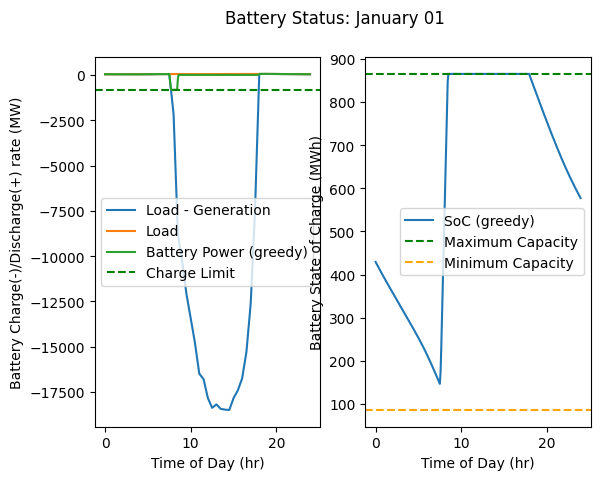

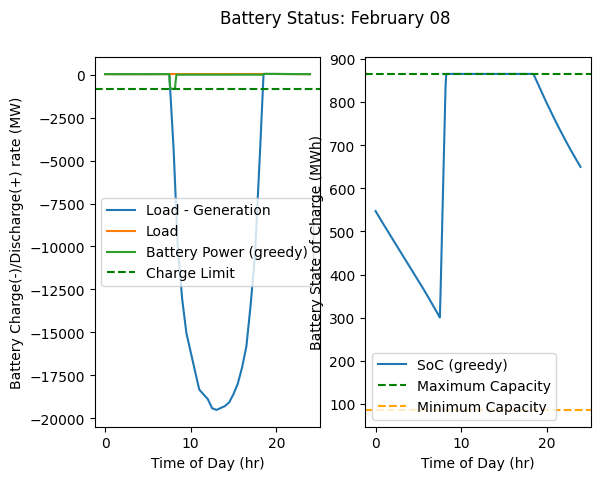

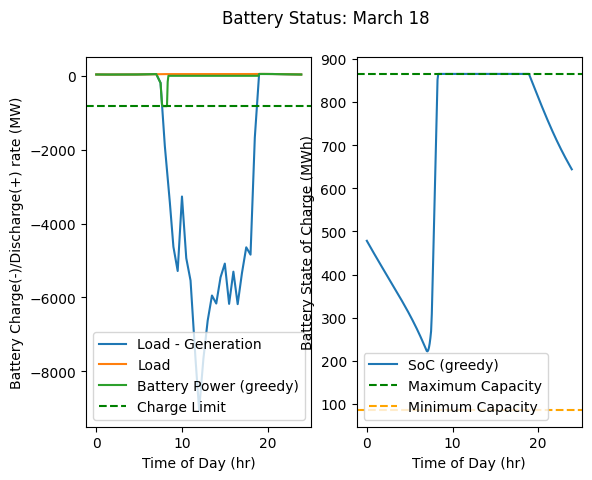

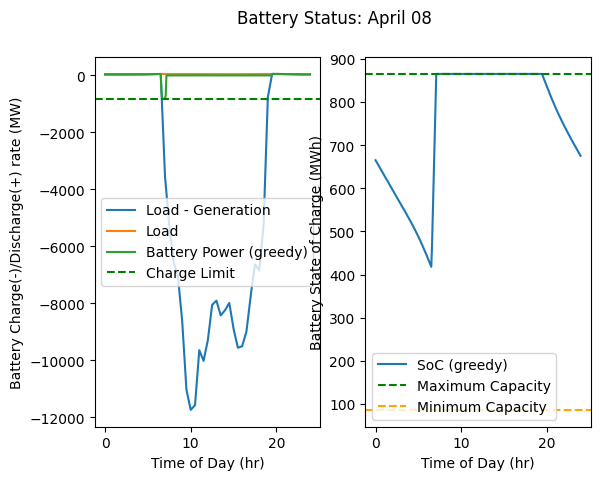

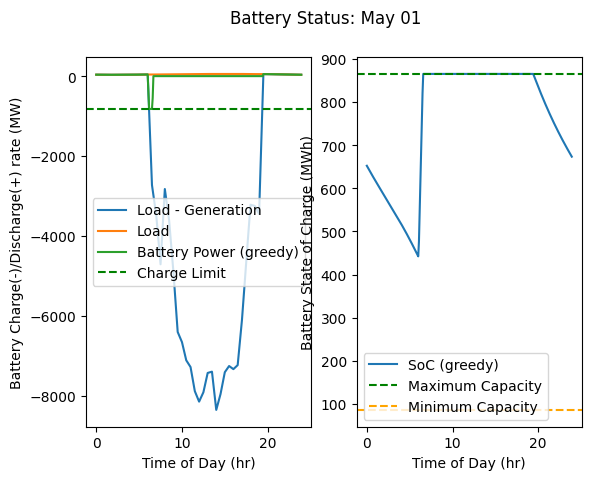

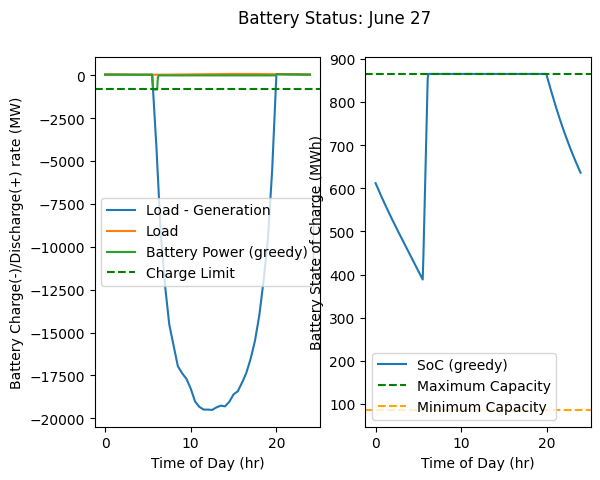

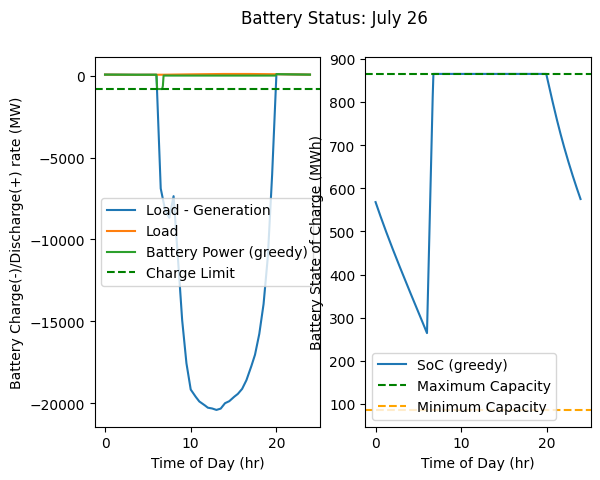

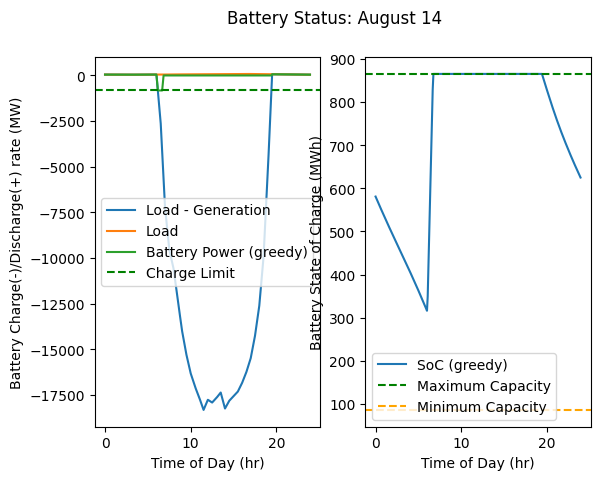

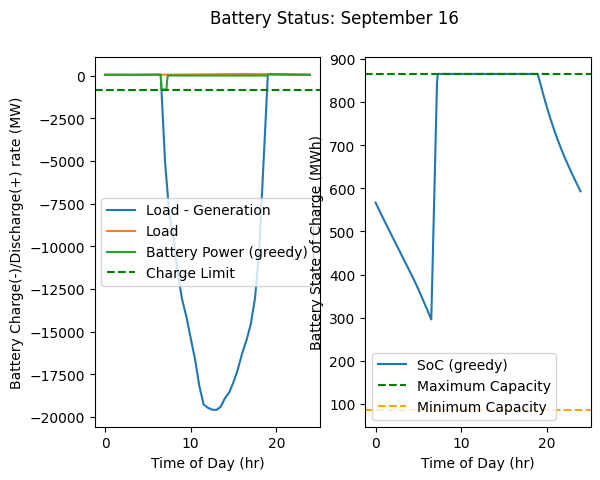

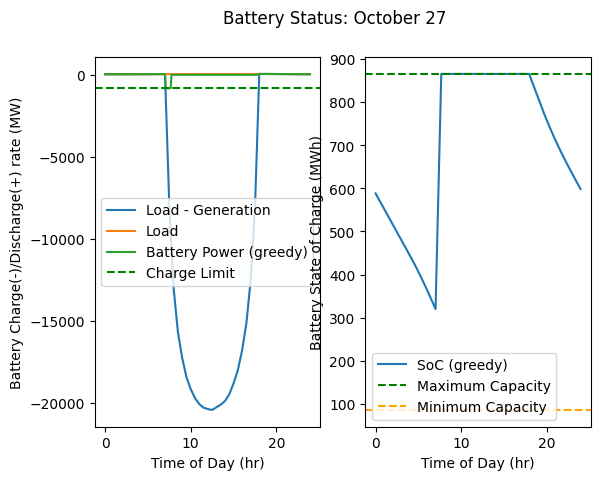

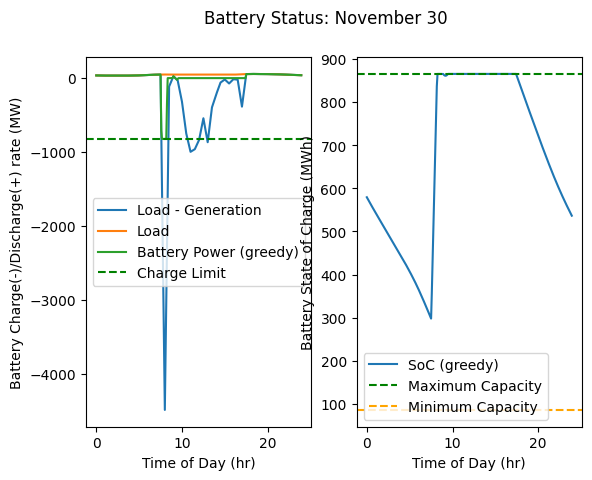

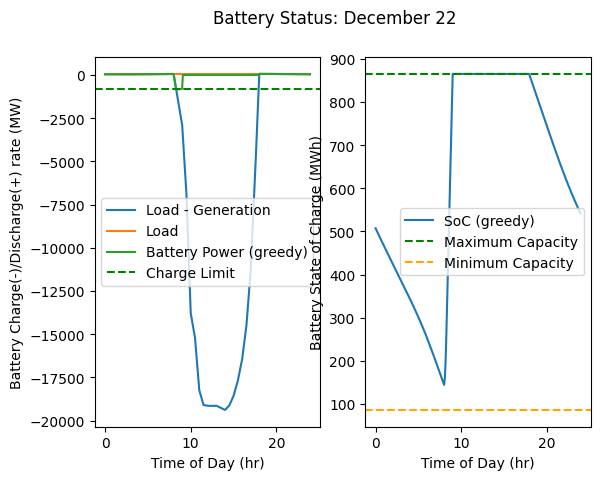

In [31]:
visualize.min_capacity_per_month(res, soc_per_day, u_batt_per_day, time_one_day, load_per_day,
                                 generation_per_day)

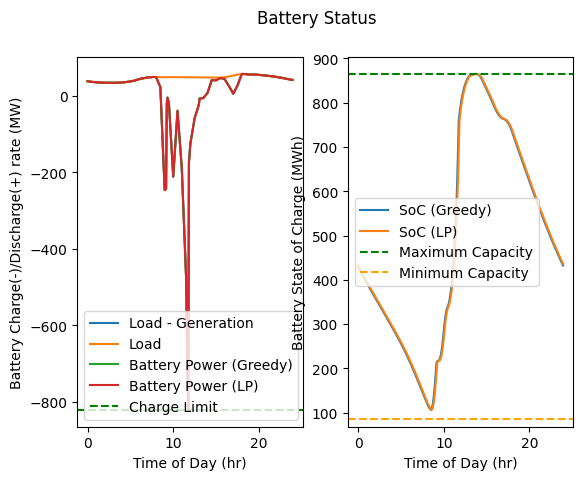

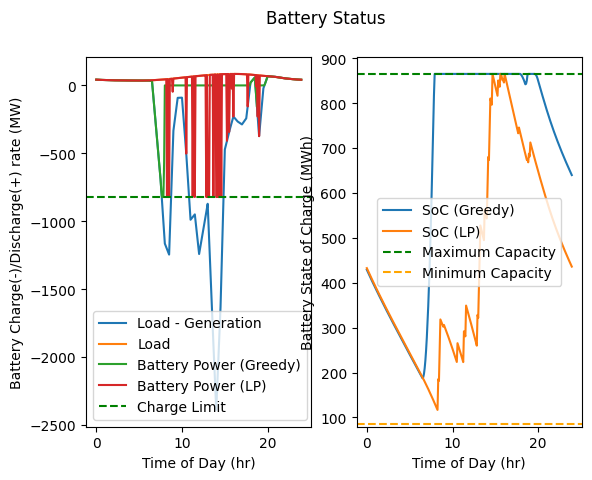

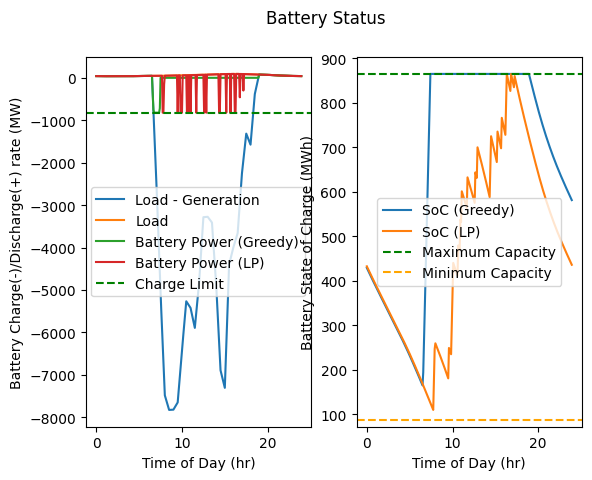

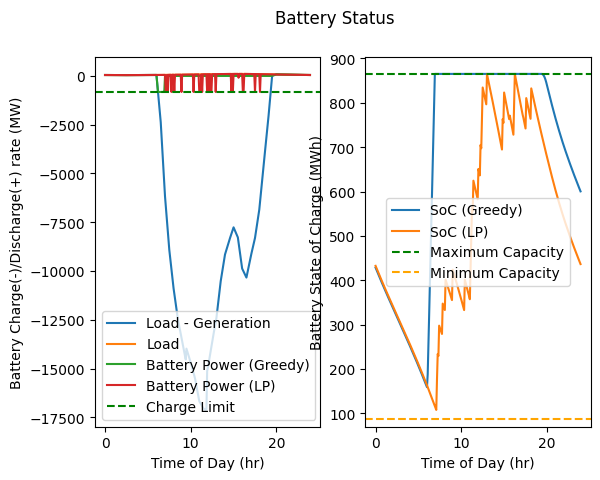

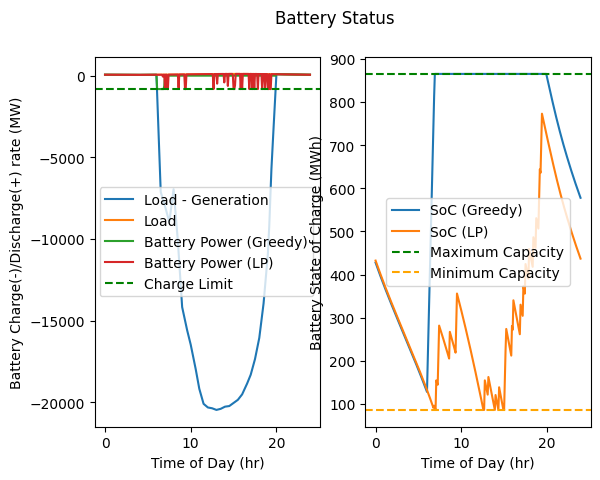

In [32]:
visualize.lp_versus_greedy_comparison(res, time_one_day, worst_load, worst_solar_pu)

In [34]:
res.E_max / res.P_battery

1.0529862514653137